In [1]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import random

base_dir = 'C:/Users/20213002/.vscode/Y3Q3 Project AI MIA'
model_name = 'CVEA'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'
batch_size = 32
img_size = 96
nr_epochs = 10
split = 0.75
latent_dim = 50

print('Model name is {}'.format(model_name))
print('Parameters-->\n Number of epochs: {}\n Batch size: {}\n Validation split: {}\n Latend dim: {}'.format(nr_epochs, batch_size, split, latent_dim))

Model name is CVEA_6, class 1
Parameters-->
 Number of epochs: 10
 Batch size: 32
 Validation split: 0.75
 Latend dim: 50


In [2]:
def get_pcam_generators(base_dir, batch_size_gen=32, class_type=0, split=0.9, img_size=96):
    """
    Uses the ImageDataGenerator function from the Keras API to return images in batches,
    train_gen for the training data and val_gen for the validation data.

    Args:
        base_dir (str): Base directory containing the dataset.
        train_batch_size (int): Batch size for training data. Default is 32.
        val_batch_size (int): Batch size for validation data. Default is 32.

    Returns:
        tuple: A tuple containing train_gen and val_gen, both are generators.
    """
    train_folder = 'train_' + str(class_type)
    val_folder = 'valid_' + str(class_type)
    # Dataset parameters
    TRAIN_PATH = os.path.join(base_dir, 'train+val', train_folder)
    VALID_PATH = os.path.join(base_dir, 'train+val', val_folder)
    RESCALING_FACTOR = 1./255
    
    # Instantiate data generators
    datagen = ImageDataGenerator(rescale=RESCALING_FACTOR,
                                 validation_split=split)

    # Generate data batches for training and validation sets
    train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size_gen,
                                            subset='training',
                                            class_mode='input')

    val_gen = datagen.flow_from_directory(VALID_PATH,
                                          target_size=(img_size, img_size),
                                          batch_size=batch_size_gen,
                                          subset='validation',
                                          class_mode='input',
                                          shuffle=False)
    return train_gen, val_gen


def construct_vae(train_gen, val_gen, weights_filepath, model_name, nr_epochs=1, latent_dim=2, batch_size=32, img_size=96):
    # Define input shape and latent dimension
    input_shape = (img_size, img_size, 3)
    # Encoder network
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling function
    @tf.function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Reparameterization trick
    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder network
    decoder_input = Input(K.int_shape(z)[1:])
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
    x = Reshape(shape_before_flattening[1:])(x)
    x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
    x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
    x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Define the VAE model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_input, x, name='decoder')
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name=model_name)

    # Define the VAE loss function
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
    B = 1000   
    vae_loss = K.mean(B * reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.add_metric(kl_loss, name="kl_loss")
    vae.add_metric(reconstruction_loss, name="reconstruction_loss")
    vae.compile(optimizer='adam')

    model_json = vae.to_json() # serialize model to JSON
    with open(model_name, 'w') as json_file:
        json_file.write(model_json)

    checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    tensorboard = TensorBoard(log_dir=os.path.join('logs', model_name))
    callbacks_list = [checkpoint, tensorboard]

    train_steps = train_gen.n // train_gen.batch_size
    val_steps = val_gen.n // val_gen.batch_size
    
    vae.fit(train_gen, 
            steps_per_epoch=train_steps, 
            epochs=nr_epochs, 
            batch_size=batch_size, 
            validation_data=val_gen, 
            validation_steps=val_steps,
            callbacks=callbacks_list)
    return vae



def reconstruct_img(vae, val_gen, img_size=96):
    decoded_imgs = vae.predict(val_gen)
    # Display the original and reconstructed images

    n = 10 # number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display the original image
        ax = plt.subplot(2, n, i + 1)
        # print(val_gen.shape)
        img, label = val_gen.next()
        plt.imshow(img[0])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()



def generate_new_img(vae, base_dir, class_type=0, num_samples=10, delete_files=True, img_size=96):
    random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))
    decoded_imgs = vae.predict(random_latent_vectors)
    # Path to the directory where you want to save the images
    save_dir = base_dir + "/train_new/{}/".format(str(class_type))

    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    for file in os.listdir(save_dir):
        if file.endswith('.jpg') and delete_files == True:
            os.remove(save_dir + file)

    # Iterate through existing images
    for i in range(len(decoded_imgs)):
        img = decoded_imgs[i].reshape(img_size, img_size,3)
        # Generate a random name for the image
        random_name = ''.join(random.choices('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ', k=10))
        # Save the image with the random name and jpg extension
        plt.imsave(os.path.join(save_dir, random_name + ".jpg"), img)

    print("Images saved to:", save_dir)

Train model functions:

Found 18000 images belonging to 1 classes.
Found 6000 images belonging to 1 classes.
Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 135382368256.0000 - kl_loss: 135502897152.0000 - reconstruction_loss: 1088.8281
Epoch 1: val_loss improved from inf to 957093.62500, saving model to CVEA_6_weights.hdf5


c:\Users\20213002\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


562/562 [==============================] - 1496s 3s/step - loss: 135382368256.0000 - kl_loss: 135502897152.0000 - reconstruction_loss: 1088.8281 - val_loss: 957093.6250 - val_kl_loss: 247.1876 - val_reconstruction_loss: 956.8460
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 940328.3750 - kl_loss: 264.1505 - reconstruction_loss: 940.0641
Epoch 2: val_loss improved from 957093.62500 to 916937.68750, saving model to CVEA_6_weights.hdf5
562/562 [==============================] - 1562s 3s/step - loss: 940328.3750 - kl_loss: 264.1505 - reconstruction_loss: 940.0641 - val_loss: 916937.6875 - val_kl_loss: 271.2984 - val_reconstruction_loss: 916.6664
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 907469.2500 - kl_loss: 271.0257 - reconstruction_loss: 907.1973
Epoch 3: val_loss improved from 916937.68750 to 897939.00000, saving model to CVEA_6_weights.hdf5
562/562 [==============================] - 1569s 3s/step - loss: 907469.2500 - kl_loss: 271.02

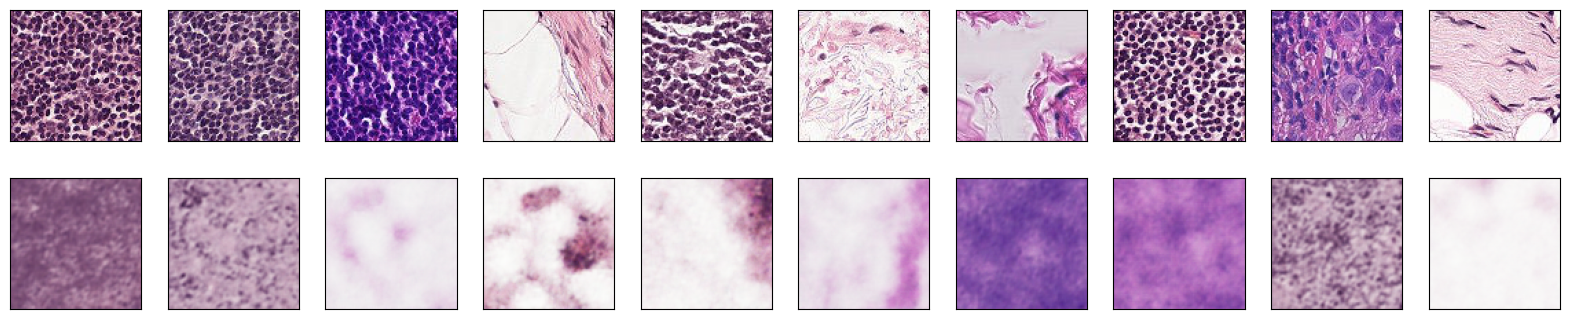

1/1 [==============================] - 1s 588ms/step
Images saved to: C:/Users/20213002/.vscode/Y3Q3 Project AI MIA/train_new/0/
Found 18000 images belonging to 1 classes.
Found 6000 images belonging to 1 classes.
Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 973018.3125 - kl_loss: 417.1381 - reconstruction_loss: 972.6008
Epoch 1: val_loss improved from inf to 906206.37500, saving model to CVEA_6_weights.hdf5
562/562 [==============================] - 2130s 4s/step - loss: 973018.3125 - kl_loss: 417.1381 - reconstruction_loss: 972.6008 - val_loss: 906206.3750 - val_kl_loss: 270.3372 - val_reconstruction_loss: 905.9362
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 834330.6875 - kl_loss: 295.3520 - reconstruction_loss: 834.0352
Epoch 2: val_loss improved from 906206.37500 to 787443.87500, saving model to CVEA_6_weights.hdf5
562/562 [==============================] - 1657s 3s/step - loss: 834330.6875 - kl_loss: 295.3520 - reconstruction_loss

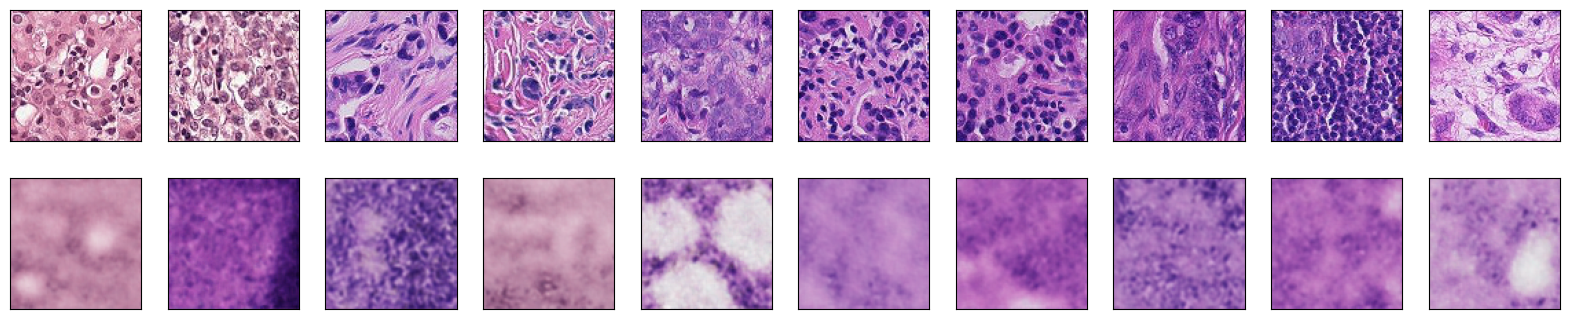

1/1 [==============================] - 0s 492ms/step
Images saved to: C:/Users/20213002/.vscode/Y3Q3 Project AI MIA/train_new/1/


In [3]:
# Perform autoencoder for specified classes (for both classes = [0,1])
classes = [0,1]
for i in classes:
    model_board = model_name + '_' + str(i)
    train_gen, val_gen = get_pcam_generators(base_dir, batch_size_gen=batch_size, split=split, class_type=i)
    vae = construct_vae(train_gen, val_gen, weights_filepath, model_board, nr_epochs, latent_dim)
    reconstruct_img(vae, val_gen)
    generate_new_img(vae, base_dir, class_type=i, num_samples=15)